In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime, minimize_scalar

In [2]:
import matplotlib as mpl
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33

### CONVERGES ### 
path = "2205.02081/SLY230A.csv"
# path = "2205.02081/SLY4.csv"
# path = "2205.02081/NL3.csv"

### KINDA CONVERGES ### 
# path = "eos_data/sly230a.csv"
# path = "eos_data/nl3cr.csv"

### NO CONGERENCE ###
# path = "eos_data/sly.csv"

def lamba_metric(M, R):
    return -np.log((1-2*G*M/(c**2*R)))
def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value= "extrapolate", kind = "cubic")
    return f_e_smooth
def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth

df = pd.read_csv(path)
e, p = df_to_ep(df)
p_max = max(p)
p_min = max(1*(c**2), min(p)) 
EOS = get_ep(e, p)

In [4]:
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))
def _b(r, M):
    return (G*M)/((c**2)*r)
def _dvdr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q
def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [5]:
def _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2_inv):
    term1 = -1*(l+1)*( W - l * np.exp(v + lamda/2) * U)
    frac = -1 * ((omega*r)**2) * (np.exp(lamda/2)*(c_ad2_inv))
    term2 = frac * (U - np.exp(lamda/2)*Q*W*(c**2)/((omega*r)**2))
    return term1 + term2
def _dUdlnr(r, W, U, lamda, l, v):
    return np.exp(lamda/2 - v) * (W - l*(np.exp(v-lamda/2))*U)

In [6]:
def dedP_helper(p, e):
    return np.gradient(e, p), e
def dedP(p, e):
    dedp_helper, e_arr = dedP_helper(p, e)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "cubic")

def drhodP(e, dedp = dedP(p, e)):
    return (c**-2) * dedp(e)

In [7]:
def coupledTOV(r, VEC, init_params):
    P, M, v, W, U = VEC
    EOS, l, omega, p_min, p_max = init_params
    if P <= p_min: 
        return None
    if P >= p_max:
        return None
    if 2*_b(r, M) >= 1:
        return None
    lamda = np.log(1/(1-2*_b(r, M)))
    Q = _Q(r, P, M)
    e = EOS(P) 
    c_ad2_inv = drhodP(e)
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, Q, lamda)
    dWdlnr = _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2_inv)
    dUdlnr = _dUdlnr(r, W, U, lamda, l, v)
    dWdr = dWdlnr * 1/r
    dUdr = dUdlnr * 1/r
    ret = [dPdr, dMdr, dvdr, dWdr, dUdr]
    return ret

In [8]:
def tov(EOS, init_VEC, r_i, p_min,p_max, omega, progress = False, 
        l=2, n_iter_max = 20000):
    init_params = [EOS, l, omega, p_min, p_max]
#     r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)
    results = []
    r_list = []
    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max
    dr = r_max/max_iter
    if progress:
        pbar = tqdm(total=max_iter)
    while r.successful() and (r.y[0] >= p_min):
        i+=1
        integral = r.integrate(r.t+dr)
        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
        if (r.y[0] < p_min):
            break
        if not r.successful():
            break
        results.append(integral)
        r_list.append(r.t+dr)
    if progress:
        pbar.close()
    
    results = np.array(results, dtype = float)
    p, m, v, w, u = results.T
    r = np.array(r_list)
    return p, m, r, v, w, u

In [9]:
def initial_conditions(EOS, e, p, k, km2cm = 1e5, r_i = 1):
    p0 = p[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = EOS(p_c)
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
    omega = 2*(2*np.pi) #Arbitrary guess
    l=2
    v0 = -1 # Two step integration optimization: similar to phi previously.
    W0 = 1
    U0 = W0/(l * np.exp(v0))
    init_VEC = [p_c, m0, v0, W0, U0]
    p_max = max(p)
    p_min = max(c**2, min(p)) 
    return km2cm, r_i, p0, e0, p_c, e_c, m0, omega, l, v0, W0, U0, init_VEC, p_min, p_max

def surface_conditions(p, m, r_arr, v, w, u):
    max_idx = np.argmax(m) - 1
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]
    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)
    return max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, schild, interior

# DIMENSIONED CHECKED
def boundary_wu(r_R, m_R, omega, w_R, u_R):
    frac1 = (omega**2 * r_R ** 3)/(G*m_R)
    return frac1 * np.sqrt(1-(2*G*m_R)/(r_R * (c**2))) - w_R/u_R

def print_params(p, m, r_arr, v, w, u):
    max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
    schild, interior = surface_conditions(p, m, r_arr, v, w, u)
    print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
    print(f"Interior Surface: {interior:.8f}")
    print(f"Exterior Surface: {schild:.8f}")
    print(f"v0: {v0}")
    print(f"Lamda: {lamba_metric(m_R, r_R)}")
    print(f"Boundary Term: {boundary_wu(r_R, m_R, omega, w_R, u_R)}")
    return None

In [10]:
km2cm, r_i, p0, e0, p_c, e_c, m0, omega, l, \
v0, W0, U0, init_VEC, p_min, p_max = initial_conditions(EOS, e, p, -8)

p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i,p_min,p_max, 
                           omega, progress = True, l = l)

max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
schild, interior = surface_conditions(p, m, r_arr, v, w, u)

print("== First Integration == ")
print_params(p, m, r_arr, v, w, u)

# Update init_VEC
v_ext = -lamba_metric(m_R, r_R)
v_int = v_R #At surface
delta_v = v_int - v_ext
v0 =  v0 - delta_v
U0 = W0/(l * np.exp(v0))
init_VEC = [p_c, m0, v0, W0, U0]
time.sleep(0.2)

p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min,p_max, omega,
                           progress = True, l = l)

max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
schild, interior = surface_conditions(p, m, r_arr, v, w, u)

print("== Corrected Integration == ")
print_params(p, m, r_arr, v, w, u)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,



== First Integration == 
Star has mass 2.050 Msun and radius 10.007km
Interior Surface: 1.74202069
Exterior Surface: 0.39524562
v0: -1
Lamda: 0.9282478751394964
Boundary Term: -501.87388062642185



== Corrected Integration == 
Star has mass 2.050 Msun and radius 10.007km
Interior Surface: 0.39524561
Exterior Surface: 0.39524559
v0: -2.4832936292157792
Lamda: 0.9282479568210633
Boundary Term: -107.59636595129938


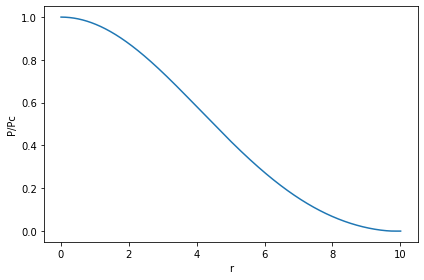

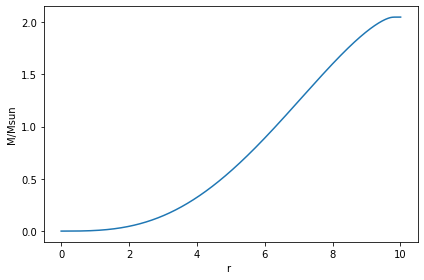

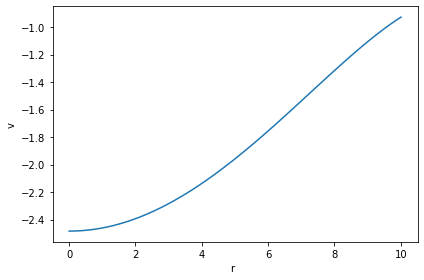

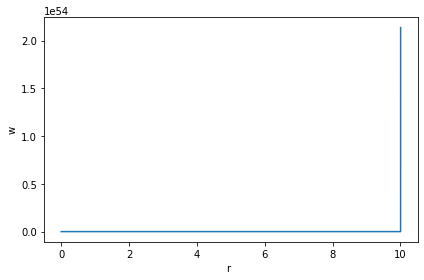

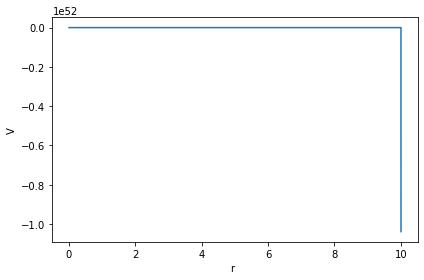

In [11]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, -u*np.exp(v))
plt.xlabel("r ")
plt.ylabel("V")
plt.show()

<IPython.core.display.Javascript object>


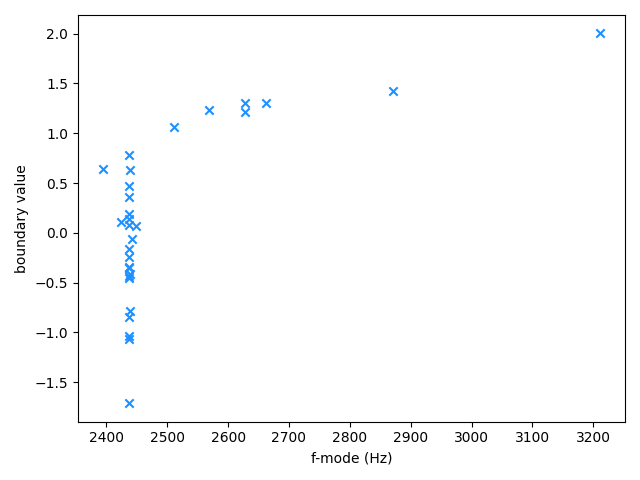

     fun: -1.7110379188037375
 message: 'Maximum number of function calls reached.'
    nfev: 30
  status: 1
 success: False
       x: 15315.18286462468

fmode: 2437.49 Hz


In [18]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (Hz)")
plt.ylabel("boundary value")

def minimize_boundary_plot(params, p = p, EOS = EOS):
    omega = params
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min,p_max, 
                               omega, l = l)

    max_idx, m_R, r_R, p_R, ec_R, u_R, v_R, w_R, \
    schild, interior = surface_conditions(p, m, r_arr, v, w, u)

    loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
    ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
    fig.canvas.draw()
    return loss

def optimize_fmode(func, m_R, r_R, newt_approx = False):
    if newt_approx: 
#         omega_min = 2*np.pi * (0.60e3 + 25e-6 * np.sqrt(m_R/(r_R**3)))
#         omega_max = 2*np.pi * (0.70e3 + 48e-6 * np.sqrt(m_R/(r_R**3)))
        omega_min = 2*np.pi * (0.60e3 + 23e-6 * np.sqrt(m_R/(r_R**3)))    
        omega_max = 2*np.pi * (0.70e3 + 50e-6 * np.sqrt(m_R/(r_R**3)))
        res = minimize_scalar(func, 
                              bounds=(omega_min, omega_max), 
                              method='bounded', 
                             options = {"maxiter":30})
        omg = res.x
        
    else: 
        omega_guess = (2*np.pi) * (0.70e3 + 30e-6 * np.sqrt(m_R/(r_R**3)))
        init_guess = [omega_guess]
        res = minimize(func, x0 = init_guess, method='Nelder-Mead', 
                       options = {"disp": True, "maxiter":15})
        omg = res.x[0]
        
    f = omg/(2*np.pi)
    return res, f

res, f = optimize_fmode(minimize_boundary_plot, 
                        m_R, r_R, newt_approx = True)
mpl.use(old_backend) # Delete when shifting over to python
display(res)
print(f"fmode: {f:.2f} Hz")

In [13]:
# 0.78e3 + 25e-6 * np.sqrt(m_R/(r_R**3)) #ArXiv 1501.02970
(0.40e3 + 25e-6 * np.sqrt(m_R/(r_R**3))) #ArXiv 1501.02970

1994.3500559537526